In [19]:
import numpy as np
from pathlib import Path
import json
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pyspiel
from tqdm import tqdm
import utils.terminals_np as terminals
from scipy.stats import sem

In [20]:
def get_summary_stats(A):
    stats = {}
    stats['min'] = np.min(A)
    stats['max'] = np.max(A)
    stats['mean'] = np.mean(A)
    stats['std err'] = sem(A)
    return stats

In [21]:
ROOT = Path('results/poly_leduc_cfr_plus')
data = []

vulns = np.zeros(30)
bounds = np.zeros(30)
deltas = np.zeros(30)
gammas = np.zeros(30)
for run_idx in range(30):
    log = json.load(open(ROOT/str(run_idx)/'log.json'))
    vulns[run_idx] = log['vuln']
    bounds [run_idx] = log['bounds'][-1]
    deltas[run_idx] = log['delta'][-1]
    gammas[run_idx] = log['gamma'][-1]

In [3]:
sort_idxs = np.argsort(bounds)
bounds = bounds[sort_idxs]
vulns = vulns[sort_idxs]
gammas = gammas[sort_idxs]
deltas = deltas[sort_idxs]

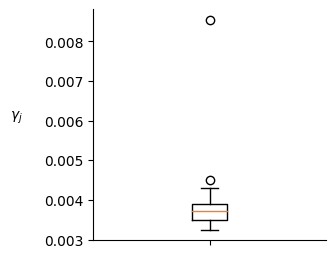

In [9]:
fig, ax = plt.subplots(figsize=(3, 3))
ax.boxplot(gammas, positions=[0], labels=[''])
ax.set_ylabel(r'$\gamma_j$', rotation=0, labelpad=20)
ax.spines[['right', 'top']].set_visible(False)
plt.savefig('figures/leduc_gammas.pdf', bbox_inches='tight')

In [23]:
get_summary_stats(gammas)

{'min': 0.0032446756958961487,
 'max': 0.00854514166712761,
 'mean': 0.0038738273084163665,
 'std err': 0.0001697711616250471}

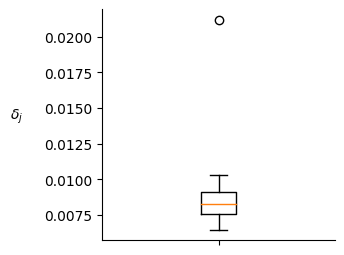

In [10]:
fig, ax = plt.subplots(figsize=(3, 3))
ax.boxplot(deltas, positions=[0], labels=[''])
ax.set_ylabel(r'$\delta_j$', rotation=0, labelpad=20)
ax.spines[['right', 'top']].set_visible(False)
plt.savefig('figures/leduc_deltas.pdf', bbox_inches='tight')

In [24]:
get_summary_stats(deltas)

{'min': 0.006463110446929932,
 'max': 0.021185778081417084,
 'mean': 0.008748250703016916,
 'std err': 0.000464378242729593}

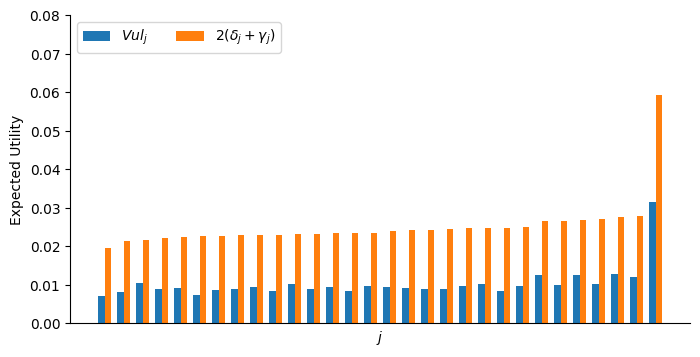

In [11]:
x = np.arange(len(vulns))  # the label locations
width = 1/3  # the width of the bars
multiplier = 0
fig, ax = plt.subplots(figsize=(8, 4))

# for vuln
offset = width * multiplier
rects = ax.bar(x + offset, vulns, width, label=r'$Vul_j$')
multiplier += 1

# for bounds
offset = width * multiplier
rects = ax.bar(x + offset, bounds, width, label=r'$2 (\delta_j+ \gamma_j) $')
multiplier += 1

ax.set_ylabel('Expected Utility')
ax.set_xlabel(r'$j$')
ax.set_xticks([])
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 0.08)
ax.spines[['right', 'top']].set_visible(False)
plt.savefig('figures/leduc_bounds.pdf', bbox_inches='tight')

In [25]:
get_summary_stats(bounds/vulns)

{'min': 1.8891195467722506,
 'max': 3.0459446994926935,
 'mean': 2.5113294278760794,
 'std err': 0.048533767512612985}

# Total Variation (TV)

In [14]:
def get_TV(reach_probs):
    num_strats = len(reach_probs)
    TV = np.zeros((num_strats, num_strats)) # will store total variaion
    for i_1, r_1 in enumerate(tqdm(reach_probs)):
        for i_2, r_2 in enumerate(reach_probs):
            TV[i_1, i_2] =  np.sum(np.abs(r_1- r_2))/2
    return np.max(TV)

In [15]:
NUM_PLAYERS = 3
NUM_STRATS = 900
GAME = 'leduc_poker'
game = pyspiel.load_game(GAME, {"players": NUM_PLAYERS})
root = Path('cfr/cfr_plus_leduc')
chance_prob = terminals.chance_terminal_reach_probs(game)

tvs = np.zeros(30)
for run_idx, run in enumerate(tqdm(range(30))):
    reach_probs = []
    start = run*30
    for strat_run in range(start, start+30):
        r = chance_prob.copy()
        for p in range(NUM_PLAYERS):
            r *= np.load(root/str(strat_run)/'strats'/('{}.npy'.format(p)))
        reach_probs.append(r)
    reach_probs = np.array(reach_probs)
    tvs[run_idx] = get_TV(reach_probs)

100%|██████████| 30/30 [01:12<00:00,  2.41s/it]


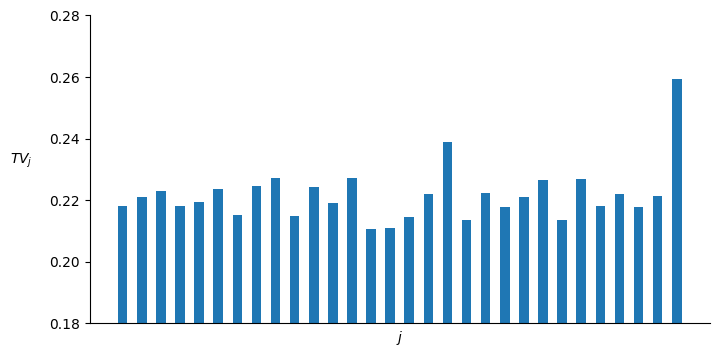

In [18]:
sorted_tvs = tvs[sort_idxs]

x = np.arange(len(vulns))  # the label locations
width = 0.5  # the width of the bars
multiplier = 0
multiplier = 0
fig, ax = plt.subplots(figsize=(8, 4))

# for vuln
offset = width * multiplier
rects = ax.bar(x + offset, sorted_tvs, width)

ax.set_ylabel(r'$TV_j$', rotation=0, labelpad=20)
ax.set_xlabel(r'$j$')
ax.set_ylim(0.18, 0.28)
ax.set_xticks([])
ax.spines[['right', 'top']].set_visible(False)
plt.savefig('figures/leduc_TV.pdf', bbox_inches='tight')

In [26]:
get_summary_stats(tvs)

{'min': 0.2107856179320977,
 'max': 0.2593958902798726,
 'mean': 0.22178619110477035,
 'std err': 0.0016717483781393827}

In [107]:
epsilons = np.zeros((30, 30, 11, 3))
for run_idx, run in enumerate(tqdm(range(30))):
    reach_probs = []
    start = run*30
    for strat_run in range(start, start+30):
        for itr_idx, itr in enumerate(range(0, 1100, 100)):
            epsilons_run = np.load(root/str(strat_run)/'epsilons'/('{}.npy'.format(itr)))
            epsilons[run_idx, strat_run%30, itr_idx, :] = epsilons_run

100%|██████████| 30/30 [00:00<00:00, 32.78it/s]


In [112]:
epsilons_final = np.zeros((900, 3))
for p in range(3):
    epsilons_final[:, p] = epsilons[:,:, -1, p].flatten()

In [ ]:
np.max(epsilons) # the maximum epsilon